# Неделя 7: NLP

## Генерация текста с помощью модели **GPT**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -qq /content/news.csv.zip

In [ ]:
!pip install -q transformers

In [ ]:
import numpy as np
import pandas as pd
import re
import random

import torch
from tqdm.notebook import tqdm
import transformers
from torch.optim import AdamW

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from nltk.corpus import stopwords 

# from nltk.stem import 
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import RegexpTokenizer

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import re

In [ ]:
# Загружаем токенайзер модели
from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('sberbank-ai/rugpt3small_based_on_gpt2')

Downloading:   0%|          | 0.00/1.63M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608 [00:00<?, ?B/s]

## Загружаем датасет из кагла, выбираем только новости из Lenta

In [ ]:
news = pd.read_csv('/content/news.csv')

In [ ]:
news

,source,title,text,publication_date,rubric,subrubric,tags
0,lenta.ru,Синий богатырь,В 1930-е годы Советский Союз охватила лихорадк...,2020-08-30T00:01:00+03:00,Экономика,Госэкономика,NaN
1,lenta.ru,Загитова согласилась вести «Ледниковый период»,Олимпийская чемпионка по фигурному катанию Ал...,2020-08-31T20:04:00+03:00,Спорт,Зимние виды,NaN
2,lenta.ru,Объяснена опасность однообразного питания,Российский врач-диетолог Римма Мойсенко объясн...,2020-08-31T20:07:00+03:00,Из жизни,Еда,NaN
3,lenta.ru,«Предохраняться? А зачем?»,В 2019 году телеканал «Ю» запустил адаптацию з...,2020-08-30T00:04:00+03:00,Интернет и СМИ,ТВ и радио,NaN
4,lenta.ru,Ефремов систематически употреблял наркотики,Актер Михаил Ефремов систематически употребл...,2020-08-31T18:27:00+03:00,Культура,Кино,NaN
...,...,...,...,...,...,...,...
21668,tjournal.ru,\n Россия прекратил...,\n\n \n \n \n \n \n...,1578056674,NaN,NaN,NaN
21669,tjournal.ru,\n Во Владивостоке ...,\n\n \n \n \n \n \n...,1577866951,NaN,NaN,NaN
21670,tjournal.ru,\n Дым от австралий...,\n\n \n \n \n \n \n...,1577864124,NaN,NaN,NaN
21671,tjournal.ru,\n Около 200 жителе...,\n\n \n \n \n \n \n...,1577894168,NaN,NaN,NaN


In [ ]:
def clean(text):
    # text = text.lower()
    text = re.sub('\n{1,}', '', text)
    text = re.sub('\s{2,}', ' ', text)
    # text = re.sub(r'<.*"?&$>',' ', text)
    return text

In [ ]:
def length(text):
  return len(text.split(' '))

In [ ]:
news['length_in_words'] = news['text'].apply(length)

In [ ]:
news = news[news['source'] == 'lenta.ru']

In [ ]:
news['text'] = news['text'].apply(clean)

In [ ]:
news['fake'] = 0
news[['text', 'fake']]

,text,fake
0,В 1930-е годы Советский Союз охватила лихорадк...,0
1,Олимпийская чемпионка по фигурному катанию Али...,0
2,Российский врач-диетолог Римма Мойсенко объясн...,0
3,В 2019 году телеканал «Ю» запустил адаптацию з...,0
4,Актер Михаил Ефремов систематически употреблял...,0
...,...,...
4505,C 1 января Болгария начала получать российский...,0
4506,В России вступили в силу новые правила содержа...,0
4507,Российский певец Сергей Лазарев объяснил свой ...,0
4508,Президент США Дональд Трамп заявил о нежелании...,0


In [ ]:
text_len = [len(x) for x in news['text']]
news['text len'] = text_len
news

## вытаскиваем затравку для генерации новости - пусть это будет начало настоящей новости

In [ ]:
def beginning(text):
  result = ''
  stop = np.random.randint(3, 6)
  
  words = text.split(' ')

  return ' '.join(words[:stop])

In [ ]:
news['begin'] = news['text'].apply(beginning)

In [ ]:
news

,source,title,text,publication_date,rubric,subrubric,tags,fake,length_in_words,begin
0,lenta.ru,Синий богатырь,В 1930-е годы Советский Союз охватила лихорадк...,2020-08-30T00:01:00+03:00,Экономика,Госэкономика,NaN,0,1955,В 1930-е годы
1,lenta.ru,Загитова согласилась вести «Ледниковый период»,Олимпийская чемпионка по фигурному катанию Али...,2020-08-31T20:04:00+03:00,Спорт,Зимние виды,NaN,0,154,Олимпийская чемпионка по фигурному катанию
2,lenta.ru,Объяснена опасность однообразного питания,Российский врач-диетолог Римма Мойсенко объясн...,2020-08-31T20:07:00+03:00,Из жизни,Еда,NaN,0,137,Российский врач-диетолог Римма Мойсенко объясн...
3,lenta.ru,«Предохраняться? А зачем?»,В 2019 году телеканал «Ю» запустил адаптацию з...,2020-08-30T00:04:00+03:00,Интернет и СМИ,ТВ и радио,NaN,0,3021,В 2019 году
4,lenta.ru,Ефремов систематически употреблял наркотики,Актер Михаил Ефремов систематически употреблял...,2020-08-31T18:27:00+03:00,Культура,Кино,NaN,0,139,Актер Михаил Ефремов систематически
...,...,...,...,...,...,...,...,...,...,...
4505,lenta.ru,Болгария начала получать газ из «Турецкого пот...,C 1 января Болгария начала получать российский...,2020-01-01T10:24:31+03:00,Экономика,Госэкономика,NaN,0,224,C 1 января Болгария
4506,lenta.ru,В России изменили правила содержания животных,В России вступили в силу новые правила содержа...,2020-01-01T08:38:00+03:00,Россия,Общество,NaN,0,292,В России вступили
4507,lenta.ru,Лазарев объяснил свой проигрыш на «Евровидении»,Российский певец Сергей Лазарев объяснил свой ...,2020-01-01T07:22:41+03:00,Культура,Музыка,NaN,0,138,Российский певец Сергей
4508,lenta.ru,Трамп заявил о нежелании воевать с Ираном,Президент США Дональд Трамп заявил о нежелании...,2020-01-01T06:14:10+03:00,Мир,Политика,NaN,0,131,Президент США Дональд


count    4510.000000
mean      184.397339
std       157.558472
min        44.000000
25%       131.000000
50%       162.000000
75%       202.000000
max      3857.000000
Name: length_in_words, dtype: float64


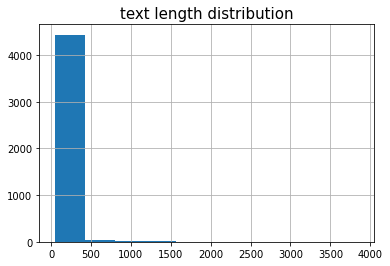

In [ ]:
print(news['length_in_words'].describe())

news['length_in_words'].hist()
plt.title('text length distribution', size=15)
plt.show()

##оставляем только новости средней длины

In [ ]:
news = news[news['length_in_words'] >200]
news = news[news['length_in_words'] <500]

In [ ]:
news['length_in_words'].sum()

831632

## склеиваем все в один текст, чтобы затем подать его на обучение модели

In [ ]:
text = ''
for i in range(len(news)):
  text = text + news.loc[i, 'text']

In [ ]:
text

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# токенизируем текст
tokens = tokenizer.encode(text, add_special_tokens=True)
tokens = np.array(tokens)
print(len(tokens))
tokens[:10]

1238905


array([  677, 13507,    17,   263,  3142, 26179, 10134, 45319, 14273,
       11599])

In [ ]:
# разбиваем на train и test

l = len(tokens)//15
train = []
test = []
for i in range(15):
    if i%5 > 0:
        train.extend(tokens[i*l: (i+1)*l])
    else:
        test.extend(tokens[i*l: (i+1)*l])
train = np.array(train)
test = np.array(test)

print(len(tokens), len(train), len(test))

1238905 991116 247779


In [ ]:
from transformers import GPT2LMHeadModel

# Эту модель подгрузим и далее обучим
model = GPT2LMHeadModel.from_pretrained(
    'sberbank-ai/rugpt3small_based_on_gpt2',
    output_attentions = False,
    output_hidden_states = False,
)

model.to(device);

Downloading:   0%|          | 0.00/526M [00:00<?, ?B/s]

In [ ]:
batch_size = 8
max_len = 256
epochs = 5

n_train = len(train)//(batch_size*max_len)
n_test = len(test)//(batch_size*max_len)
print(n_train, n_test)

# устанавливаем оптимизатор
optimizer = AdamW(model.parameters(), lr = 1e-5, eps = 1e-8)

# трансформеры с трудом обучаются, для них нужны разные способы повышения 
# эффективности градиентного спуска
total_steps = n_train * epochs
scheduler = transformers.get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)


def accuracy(y_true, logits):
    return torch.mean((y_true[1:] == torch.argmax(logits, dim=2)[:-1]).float()).detach().cpu().numpy()

483 120


In [ ]:
# готовим тензоры для обучения

def prep_tensors(x, i, batch_size=batch_size, max_len=max_len):
    batch_ids = x[i*batch_size*max_len: (i+1)*batch_size*max_len]
    batch_ids = batch_ids.reshape(batch_size, max_len)
    batch_ids = torch.tensor(batch_ids).to(device)
    return batch_ids


# обучающий цикл
for epoch in range(1, epochs+1):
    print(f'epoch {epoch}/{epochs} : training')

    train_loss = []
    train_acc = []
    model.train()
    pbar = tqdm(range(n_train))
    for i in pbar:
        batch_ids = prep_tensors(train, i)

        model.zero_grad()
        loss, logits, _ = model(batch_ids,
                                token_type_ids=None,                                 
                                labels=batch_ids
                             ).values()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        train_loss.append(loss.item())
        train_acc.append(accuracy(batch_ids, logits))
        pbar.set_description(f'acc {np.mean(train_acc):.4f} loss {np.mean(train_loss):.4f}', refresh=True)

    
    print(f'epoch {epoch}/{epochs} : validation')
    model.eval()
    val_acc = []
    val_loss = []
    pbar = tqdm(range(n_test))
    for i in pbar:
        batch_ids = prep_tensors(test, i)
        with torch.no_grad():        
            loss, logits, _ = model(batch_ids, 
                                token_type_ids=None, 
                                # attention_mask=batch_mask,
                                labels=batch_ids
                                 ).values()
        
        val_loss.append(loss.item())
        val_acc.append(accuracy(batch_ids, logits))
        pbar.set_description(f'acc {np.mean(val_acc):.4f} loss {np.mean(val_loss):.4f}', refresh=True)


epoch 1/5 : training


  0%|          | 0/483 [00:00<?, ?it/s]

epoch 1/5 : validation


  0%|          | 0/120 [00:00<?, ?it/s]

epoch 2/5 : training


  0%|          | 0/483 [00:00<?, ?it/s]

epoch 2/5 : validation


  0%|          | 0/120 [00:00<?, ?it/s]

epoch 3/5 : training


  0%|          | 0/483 [00:00<?, ?it/s]

epoch 3/5 : validation


  0%|          | 0/120 [00:00<?, ?it/s]

epoch 4/5 : training


  0%|          | 0/483 [00:00<?, ?it/s]

epoch 4/5 : validation


  0%|          | 0/120 [00:00<?, ?it/s]

epoch 5/5 : training


  0%|          | 0/483 [00:00<?, ?it/s]

epoch 5/5 : validation


  0%|          | 0/120 [00:00<?, ?it/s]

In [ ]:
torch.save(model.state_dict(), '/content/fake_news.ptn')

In [ ]:
import textwrap

In [ ]:

prompt = 'Турист из Великобритании'
prompt = tokenizer.encode(prompt, return_tensors='pt').to(device)
out = model_init.generate(
    input_ids=prompt,
    max_length=150, #длина сгенернного текста
    num_beams=5,
    do_sample=True,
    temperature=10.,
    top_k=50,
    top_p=0.6,
    no_repeat_ngram_size=3, #иногда глючит
    num_return_sequences=7, # сколько текстов генерить
    ).cpu().numpy()
for out_ in out:
    print(textwrap.fill(tokenizer.decode(out_), 120), end='\n------------------\n')

In [ ]:
for out_ in out:
    print(tokenizer.decode(out_))

In [ ]:
# дообученная модель
def generate_fake(prompt):

    max_lenght = np.random.randint(50, 150)
    prompt = prompt
    prompt = tokenizer.encode(prompt, return_tensors='pt').to(device)
    out = model.generate(
        input_ids=prompt,
        max_length= max_lenght,#np.random.randint(50, 250, 1),
        num_beams=10,
        do_sample=True,
        temperature=1.0,
        top_k=60,
        top_p=0.8,
        no_repeat_ngram_size=2,
        num_return_sequences=10,
        ).cpu().numpy()

    result = tokenizer.decode(out[0])
    sents = result.split('. ')  
    if len(sents) > 1:
      return '. '.join(sents[:-1])
    else: 
        return result   

    # for out_ in out:
    #     print(textwrap.fill(tokenizer.decode(out_), 120), end='\n------------------\n')

In [ ]:
a = np.random.randint(0, len(news), 1000)
fake_news = news.loc[a, :]

## генерим колонку с фейковыми новостями по затравке из колонки begin

In [ ]:
fake_news['fake_news'] = fake_news['begin'].apply(generate_fake)

In [ ]:
fake_news[['fake_news']].to_csv('fake.csv') 

In [ ]:
for out_ in out:
  result = tokenizer.decode(out_)
  sents = result.split('. ') 
   
  print('. '.join(sents[:-1]))

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr

In [ ]:
demo = gr.Interface(generate_fake, inputs= ['text'],  outputs=['text'])

demo.launch()

In [ ]:
generate_fake('Последние исследования')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Последние исследования показали, что у пациентов с коронавирусом COVID-19 риск инфицирования выше, чем у тех, у кого он
протекает бессимптомно. Об этом сообщается в пресс-релизе, поступившем в редакцию «Ленты.ру». По последним данным, за
последние сутки в России выявили 2,5 тысячи случаев заражения, из них 1,3 тысячи — в Москве
------------------
Последние исследования показали, что у людей, страдающих от пандемии коронавируса, меньше шансов заразиться
коронавирусом, чем у тех, у кого он протекает бессимптомно. Об этом сообщает РИА Новости со ссылкой на исследование,
проведенное в Университете Джонса Хопкинса (США). В исследовании приняли участие 248 человек в возрасте от 18 до 24 лет,
которые были заражены корона
------------------
Последние исследования показали, что у людей с хроническим пандемией коронавируса COVID-19 больше шансов на
выздоровление, чем у тех, у кого коронавирус не был выявлен ранее. Об этом говорится в исследовании, опубликованном в
журнале Nature Communications. 

In [ ]:
model.to(device)